In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import pandas as pd
import rioxarray
from shapely.geometry import mapping

## Set up ERDDAP URL to access data

* science quality data erddap unique id : nsidcG02202v4nhmday
* near real-time data erddap unique id : nsidcG10016v2nhmday
* grid area erddap unique id : pstere_gridcell_N25k

In [7]:
# Set data server and data id

server = 'https://polarwatch.noaa.gov/erddap'
data_type = 'griddap'
sq_dataset_id = 'nsidcG02202v4nh1day'
nrt_dataset_id = 'nsidcG10016v2nhmday'
grid_area_id = 'pstere_gridcell_N25k'

# Set data urls
sq_url = '/'.join([server, data_type, sq_dataset_id])
nrt_url = '/'.join([server, data_type, nrt_dataset_id])
gridarea_url = '/'.join([server, data_type,grid_area_id ])

In [8]:
ds_sq = xr.open_dataset(sq_url, chunks={})
ds_sq

/Users/sunbak/miniforge3/envs/seaice/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 72GB
Dimensions:                         (time: 16416, ygrid: 448, xgrid: 304)
Coordinates:
  * time                            (time) datetime64[ns] 131kB 1978-10-25 .....
  * ygrid                           (ygrid) float32 2kB 5.838e+06 ... -5.338e+06
  * xgrid                           (xgrid) float32 1kB -3.838e+06 ... 3.738e+06
Data variables:
    cdr_seaice_conc                 (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
    melt_onset_day_cdr_seaice_conc  (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
    nsidc_bt_seaice_conc            (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
    nsidc_nt_seaice_conc            (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
    qa_of_cdr_seaice_conc           (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
    spatial_interpolation_flag      (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
    stdev_of_cdr_seaice_conc        (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
    temporal_interpolation_flag     (time, ygrid, xgrid) float32 9GB dask.array<chunksize=(16416, 448, 304), meta=np.ndarray>
Attributes: (12/65)
    _NCProperties:                                       version=2,netcdf=4.8...
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1D
    time_coverage_end:                                   2023-12-31T00:00:00Z
    time_coverage_resolution:                            P1D
    time_coverage_start:                                 1978-10-25T00:00:00Z
    title:                                               Sea Ice Concentratio...

## Get Sea ice data from 1985 to current

In [5]:
# using dask
ds_sq = xr.open_dataset(sq_url, chunks={})
ds_nrt = xr.open_dataset(nrt_url, chunks={})
ds_area = xr.open_dataset(gridarea_url, chunks={})

# select var only
da = ds_sq['cdr_seaice_conc_monthly']
da_nrt = ds_nrt['cdr_seaice_conc_monthly']
da_area = ds_area['cell_area']
da_area = da_area.rename({'x': 'xgrid', 'y': 'ygrid'})

# set all values outside of the valid range to be nan
da = da.where((da >= 0) & (da <= 1), other=float('nan'))
da_nrt = da_nrt.where((da_nrt >= 0) & (da_nrt <= 1), other=float('nan'))


ds_sq.close()
ds_nrt.close()
ds_area.close()

/Users/sunbak/miniforge3/envs/seaice/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/Users/sunbak/miniforge3/envs/seaice/lib/python3.9/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [6]:
# get time range for alt data (nrt)

sq_latest = np.max(da['time'])
nrt_latest = np.max(da_nrt['time'])

print(f'{sq_latest.dt.strftime("%Y-%m-%d")} to {nrt_latest.dt.strftime("%Y-%m-%d")}')


<xarray.DataArray 'strftime' ()> Size: 8B
array('2023-12-01', dtype=object) to <xarray.DataArray 'strftime' ()> Size: 8B
array('2024-03-01', dtype=object)


# Alaska shapefile

EPSG:6397


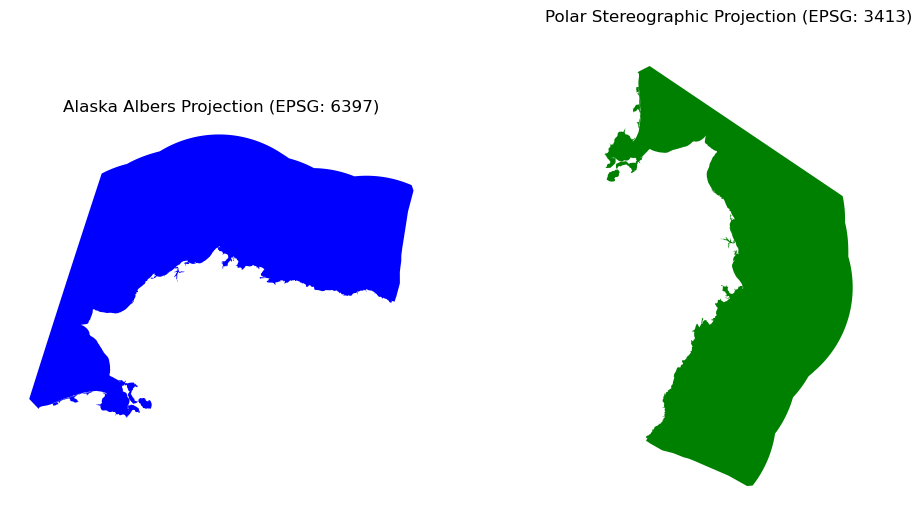

In [14]:
# Read the northern Bering shapefile
alaska_shp = gpd.read_file('data/akmarineeco/arctic_sf.shp')
print(alaska_shp.crs)

region_title = "Alaskan_Arctic"

# Transform projection to Polar Stereographic Projection
alaska_shp_proj = alaska_shp.to_crs('epsg:3413')

# Create a figure and two subplot axes
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Plot original CRS
alaska_shp.plot(ax=ax[0], color='blue')
ax[0].set_title('Alaska Albers Projection (EPSG: 6397)')
ax[0].set_axis_off()

# Plot converted CRS
alaska_shp_proj.plot(ax=ax[1], color='green')
ax[1].set_title('Polar Stereographic Projection (EPSG: 3413)')
ax[1].set_axis_off()

# Display the plots
plt.show()



In [8]:
def set_geo_specs(dat: xr.DataArray, xdim: str, ydim: str, crs: str)-> xr.DataArray:
    dat.rio.set_spatial_dims(x_dim=xdim, y_dim=ydim, inplace=True)
    dat.rio.write_crs(crs, inplace=True)
    return dat



## Clip satellite data using the shahpefile

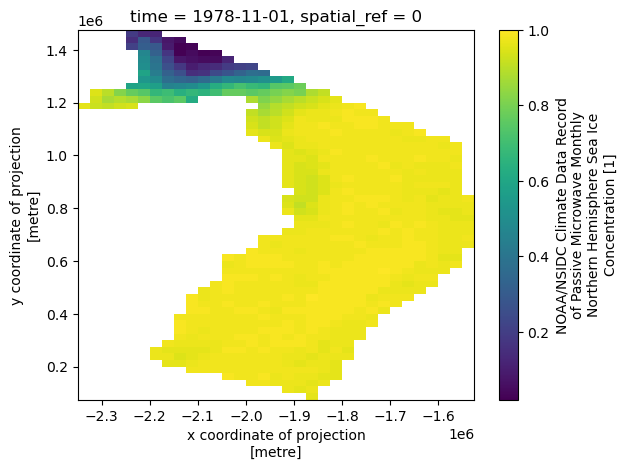

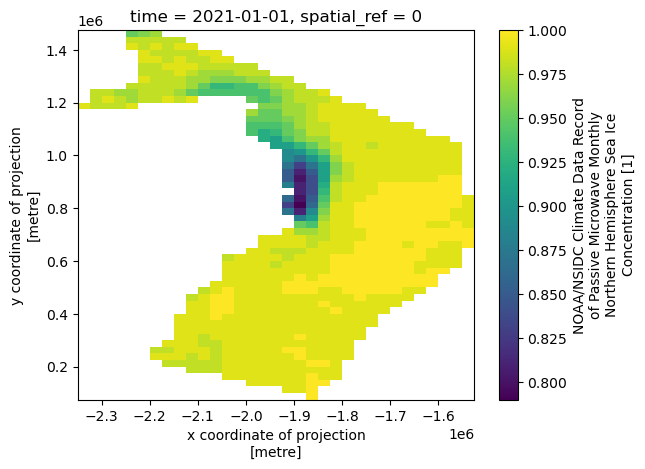

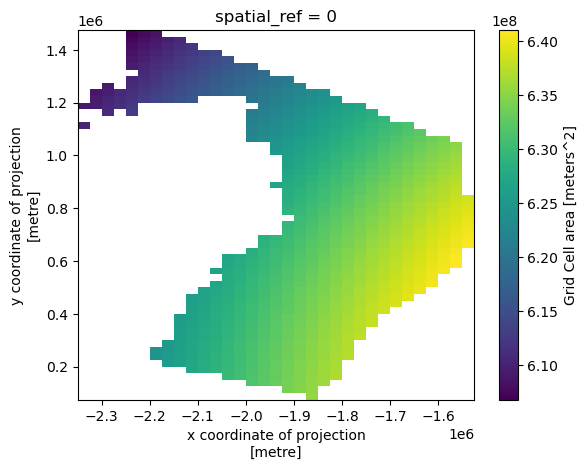

In [9]:
# Set Geospatial Specifications for all satellite data
da_area = set_geo_specs(da_area, xdim="xgrid", ydim="ygrid", crs="EPSG:3413")
da_nrt = set_geo_specs(da_nrt, xdim="xgrid", ydim="ygrid", crs="EPSG:3413")
da = set_geo_specs(da, xdim="xgrid", ydim="ygrid", crs="EPSG:3413")


clipped_da = da.rio.clip(alaska_shp_proj.geometry.apply(mapping), alaska_shp_proj.crs)
clipped_da_nrt = da_nrt.rio.clip(alaska_shp_proj.geometry.apply(mapping), alaska_shp_proj.crs)
clipped_area = da_area.rio.clip(alaska_shp_proj.geometry.apply(mapping), alaska_shp_proj.crs)

clipped_da.isel(time=0).plot()
plt.show()
clipped_da_nrt.isel(time=0).plot()
plt.show()
clipped_area.plot()
plt.show()




## Compute monthly stats for each year between 1985 and 2024

In [11]:
# Get science quality data 
ice_conc_yearly_sq = clipped_da.sel(time=slice("1985-01-01", sq_latest)) 


# If near real time (nrt) dataset has later dates, append nrt data
ice_conc_yearly = ice_conc_yearly_sq

if sq_latest < nrt_latest:
    ice_conc_yearly_nrt = clipped_da_nrt.sel(time=slice(sq_latest+pd.Timedelta(days=1), None))
    ice_conc_yearly = xr.concat([ice_conc_yearly_sq, ice_conc_yearly_nrt], dim='time')

# Add time dimension to area dataset 


# Create Sea Ice Extent Values 0 and 1 based on threshold, retaining Nan values
ice_conc_ext_yearly = xr.where(ice_conc_yearly >= 0.15, 1, 0)
ice_conc_ext_yearly = xr.where(ice_conc_yearly.isnull(), np.nan, ice_conc_ext_yearly)


# Calculate sea ice extent of each cell by multiplying binary value to grid cell area
ice_ext_yearly = ice_conc_ext_yearly * clipped_area

# Add name
ice_ext_yearly.name = 'seaice_extent'

# Add year-month 
ice_ext_yearly['time_year_month'] = ice_ext_yearly['time'].dt.strftime('%Y-%m')



In [13]:
# Sum all grid values for year-month
ice_ext_yearly_ts = (ice_ext_yearly
                     .groupby("time_year_month")
                     .sum(dim=["time", "xgrid", "ygrid"],  min_count=10)) 

# Add year and month
ice_ext_yearly_ts['year'] = ice_ext_yearly_ts['time_year_month'].str.slice(start=0, stop=4).astype(int)
ice_ext_yearly_ts['month'] = ice_ext_yearly_ts['time_year_month'].str.slice(start=5, stop=7).astype(int)


## Save time series data as CSV

In [11]:
#Convert to DataFrame
ice_ext_yearly_ts_df = (ice_ext_yearly_ts
                      .to_dataframe()
                      .reset_index()
                      .drop(['time_year_month','spatial_ref'], axis='columns'))

ice_ext_yearly_ts_df['seaice_extent'] = (ice_ext_yearly_ts_df['seaice_extent']/ 1000000).round(2)

# # Write to csv
ice_ext_yearly_ts_df.to_csv(f'{region_title}_yearly.csv', index=False)  


## Compute a Baseline from 1985-2015 and Save as CSV

In [12]:
# Compute baseline
ice_ext_baseline = (ice_ext_yearly_ts
                         .where((ice_ext_yearly_ts['year'] >= 1985) & (ice_ext_yearly_ts['year'] <= 2005), drop=True)
                         .groupby("month")
                         .mean())
ice_ext_baseline.name = 'seaice_extent'

#Convert to DataFrame
ice_ext_baseline_df = (ice_ext_baseline
                      .to_dataframe()
                      .reset_index()
                      .drop([ 'spatial_ref'], axis='columns'))


ice_ext_baseline_df['seaice_extent'] = (ice_ext_baseline_df['seaice_extent']/ 1000000).round(2)
ice_ext_baseline_df['year'] = 1111

# # Write to csv
ice_ext_baseline_df.to_csv(f'{region_title}_baseline.csv', index=False)  

# NOT NEEDED: Append data Not needed any more since I would keep the two datasets separately
#ice_ext_df = pd.concat([ice_ext_baseline_df, ice_ext_yearly_ts_df])


In [13]:
ice_ext_baseline_df

,month,seaice_extent,year
0,1,272901.95,1111
1,2,290081.04,1111
2,3,303359.51,1111
3,4,299952.28,1111
4,5,199016.27,1111
5,6,20050.31,1111
6,7,3748.86,1111
7,8,0.00,1111
8,9,1115.05,1111
9,10,3191.96,1111
